In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge


df = pd.read_csv('house-prices-dataset/house_train.csv')
house = df.copy()
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
house.shape

(1460, 81)

#### 가장 null값이 많은 컬럼명 출력

In [4]:
null_val = pd.Series(house.isna().sum())
null_sort = null_val.sort_values(ascending=False)
null_sort.head(6)

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
FireplaceQu     690
LotFrontage     259
dtype: int64

In [5]:
house.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis=1, inplace=True)

In [6]:
house.shape

(1460, 76)

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

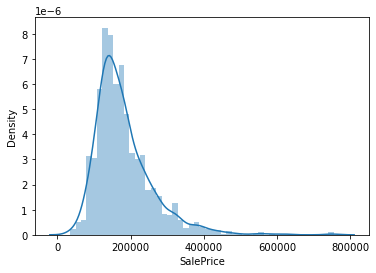

In [7]:
sns.distplot(house['SalePrice'])

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

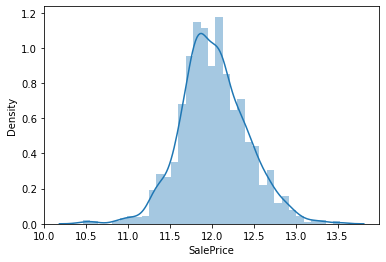

In [8]:
sns.distplot(np.log1p(house['SalePrice']))

#### 결측치가 너무 많은 몇개의 컬럼은 제거해줌
#### 결측치가 있는 컬럼 중 숫자형인 컬럼은 평균값으로 채움
#### target값인 SalePrice가 skewed형태라 log1p를 통해 정규분포형으로 변환
##### house.dtypes를 하면 데이터프레임에 있는 모든 컬럼의 dtype을 출력. null값이 있는 컬럼의 dtype을 알고 싶으므로 house.dtypes[null값이 있는 컬럼명들]로 출력

In [9]:
house.fillna(house.mean(), inplace=True)

house['SalePrice'] = np.log1p(house['SalePrice'])
null_val = house.isna().sum()[house.isna().sum()>0]
print('null값이 있는 컬럼의 dtype : ', house.dtypes[null_val.index])

null값이 있는 컬럼의 dtype :  MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [10]:
house_ohe = pd.get_dummies(house)
print(house.shape)
print(house_ohe.shape)
print('null 값이 있는 컬럼 : ', house_ohe.isna().sum()[house_ohe.isna().sum()>0])

(1460, 76)
(1460, 272)
null 값이 있는 컬럼 :  Series([], dtype: int64)


In [11]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(f'{model.__class__.__name__} log 변환된 RMSE : {rmse : .4f}')
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [12]:
X_data = house_ohe.drop('SalePrice', axis=1)
y_target = house_ohe['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target,
                                                   test_size=0.3,
                                                   random_state=5)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression log 변환된 RMSE :  0.1435
Ridge log 변환된 RMSE :  0.1372
Lasso log 변환된 RMSE :  0.1884


[0.14350328051348812, 0.13724688957455952, 0.18838115919115248]

In [13]:
def get_coef(model):
    coef = pd.Series(model.coef_, index=X_data.columns)
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

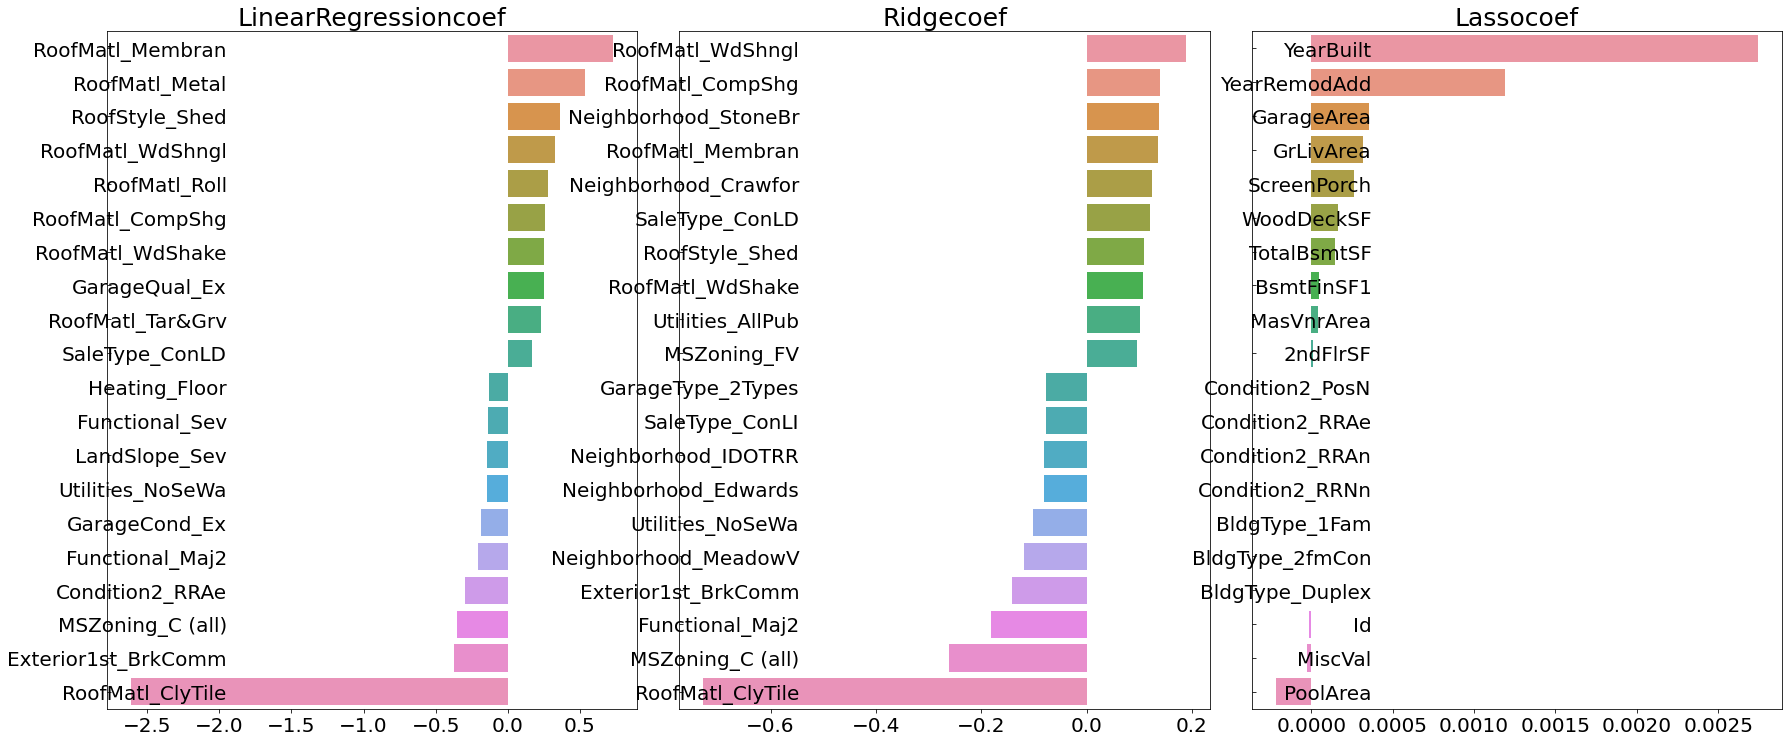

In [14]:
def coef_graph(models):
    fig, axs= plt.subplots(figsize=(24,10), ncols=3, nrows=1)
    fig.tight_layout()
    for num, model in enumerate(models):
        coef_high, coef_low = get_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        axs[num].set_title(model.__class__.__name__ + 'coef', size=25)
        axs[num].tick_params(axis='y', direction='in', pad=-120)
        for label in (axs[num].get_xticklabels() + axs[num].get_yticklabels()):
            label.set_fontsize(20)
            
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[num])
    
coef_graph(models)

In [15]:
def get_avg_cv(models):
    for model in models:
        rmse_list = np.sqrt(-1 * cross_val_score(model, X_data, y_target, scoring='neg_mean_squared_error',
                                                cv=5))
        rmse_avg = np.mean(rmse_list)
        print(f'{model.__class__.__name__} CV 평균 RMSE : {rmse_avg : .4f}')

models = [lr_reg, ridge_reg, lasso_reg]
get_avg_cv(models)

LinearRegression CV 평균 RMSE :  0.1555
Ridge CV 평균 RMSE :  0.1437
Lasso CV 평균 RMSE :  0.1976


In [16]:
def best_params(model, params):
    grid_model = GridSearchCV(model, param_grid = params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_data, y_target)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print(f'{model.__class__.__name__} CV 최적 평균 RMSE : {rmse : .4f}, 최적 alpha값 : {grid_model.best_params_}')
    return grid_model.best_estimator_

ridge_params = {'alpha' : [0.05,0.1, 1, 5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005,0.008,0.05,0.03,0.1, 0.5, 1.5 ,10]}

best_ridge = best_params(ridge_reg, ridge_params)
best_lasso = best_params(lasso_reg, lasso_params)

Ridge CV 최적 평균 RMSE :  0.1416, 최적 alpha값 : {'alpha': 10}
Lasso CV 최적 평균 RMSE :  0.1420, 최적 alpha값 : {'alpha': 0.001}


In [17]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha = 10)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha = 0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression log 변환된 RMSE :  0.1435
Ridge log 변환된 RMSE :  0.1377
Lasso log 변환된 RMSE :  0.1379


[0.14350328051348812, 0.13769393464365956, 0.13788640438408173]

In [18]:
from scipy.stats import skew

data_index = house.dtypes[house.dtypes!='object'].index
skew_data = house[data_index].apply(lambda x : skew(x))

skew_top = skew_data[skew_data>1]
skew_top.sort_values(ascending=False)

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64

In [19]:
house[skew_top.index] = np.log1p(house[skew_top.index])

In [20]:
house_ohe = pd.get_dummies(house)
X_data = house_ohe.drop('SalePrice', axis=1)
y_target = house_ohe['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3,
                                                   random_state=5)
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = best_params(ridge_reg, ridge_params)
best_lasso = best_params(lasso_reg, lasso_params)

Ridge CV 최적 평균 RMSE :  0.1274, 최적 alpha값 : {'alpha': 10}
Lasso CV 최적 평균 RMSE :  0.1251, 최적 alpha값 : {'alpha': 0.001}


LinearRegression log 변환된 RMSE :  0.1286
Ridge log 변환된 RMSE :  0.1293
Lasso log 변환된 RMSE :  0.1278


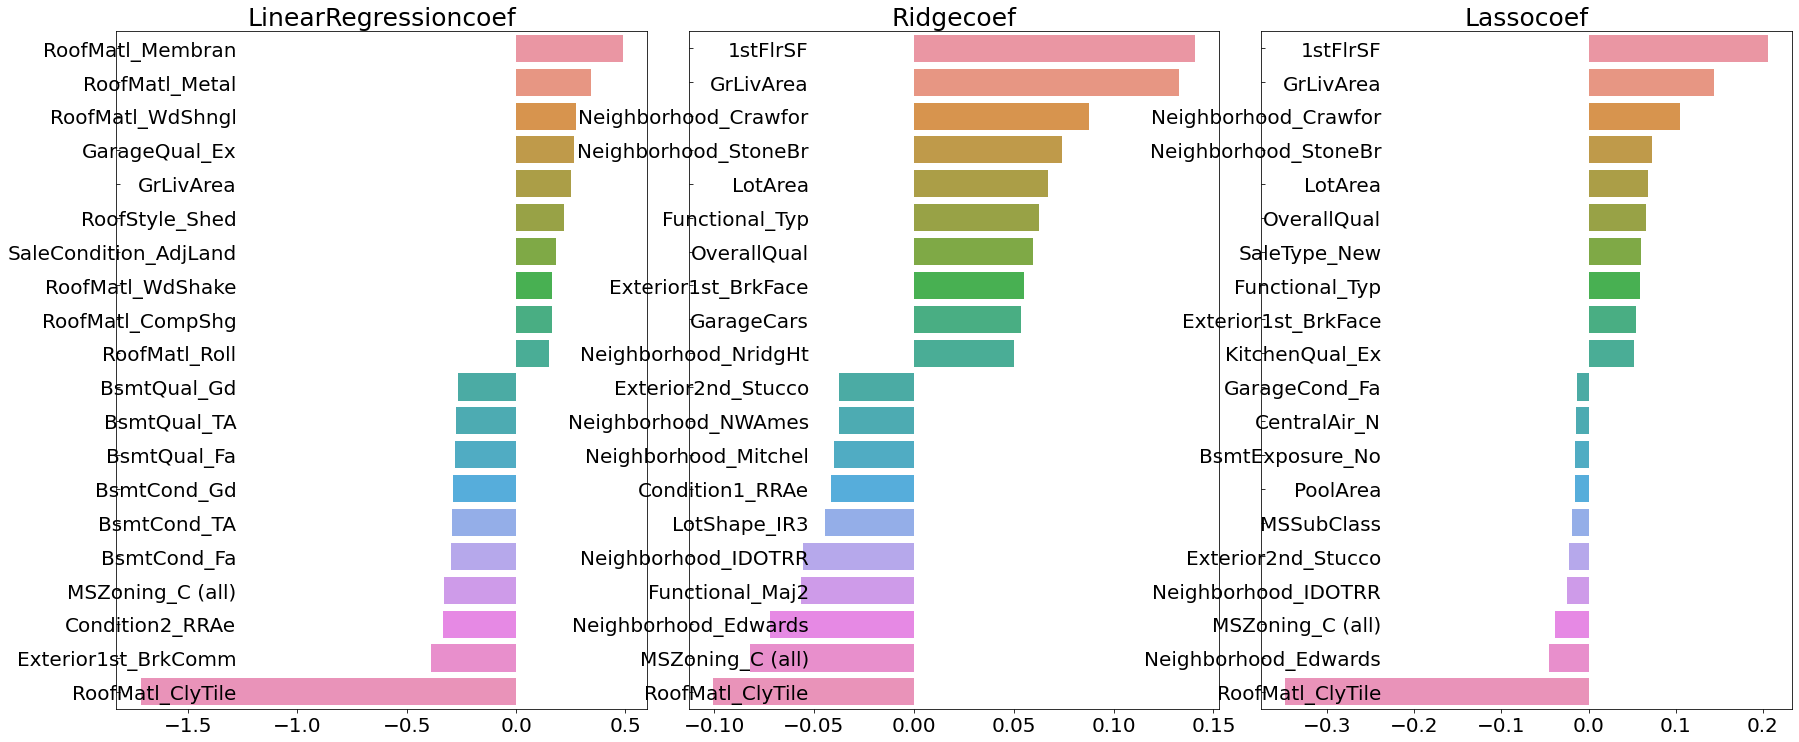

In [21]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha = 10)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha = 0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

models = [lr_reg, ridge_reg, lasso_reg]
coef_graph(models)

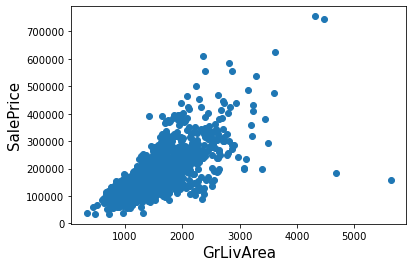

In [22]:
plt.scatter(x=df['GrLivArea'], y=df['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [23]:
cond1 = house_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_ohe['SalePrice'] < np.log1p(500000)

outlier_index= house_ohe[cond1 & cond2].index
print(outlier_index)
print(house_ohe.shape)
house_ohe.drop(outlier_index, axis=0, inplace=True)
print(house_ohe.shape)

Int64Index([523, 1298], dtype='int64')
(1460, 272)
(1458, 272)


In [24]:
X_data = house_ohe.drop('SalePrice', axis=1)
y_target = house_ohe['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target,
                                                   test_size=0.3,
                                                   random_state=5)
best_ridge = best_params(ridge_reg, ridge_params)
best_lasso = best_params(lasso_reg, lasso_params)

Ridge CV 최적 평균 RMSE :  0.1124, 최적 alpha값 : {'alpha': 8}
Lasso CV 최적 평균 RMSE :  0.1121, 최적 alpha값 : {'alpha': 0.001}


In [25]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha = 8)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

models = [lr_reg, ridge_reg, lasso_reg]
#coef_graph(models)

LinearRegression log 변환된 RMSE :  0.1247
Ridge log 변환된 RMSE :  0.1106
Lasso log 변환된 RMSE :  0.1103


### (참고) 
train_test_split의 random_state에 따라 결과값이 크게 다르게 나온다. 처음에는 전처리 단계에서 실수를 한건가, 싶을정도로 RMSE값이 안좋게 나왔는데, 전처리가 잘못됐다기보다는 
train_test_split보다는 cross validation을 하는것이 더 좋은 데이터셋이라고 결론지었다.

In [26]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators' : [1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                        subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = best_params(lgbm_reg, lgbm_params)

LGBMRegressor CV 최적 평균 RMSE :  0.1166, 최적 alpha값 : {'n_estimators': 1000}


## 스태킹 모델을 이용한 회귀예측

In [38]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def stacking_fit(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits= n_folds, shuffle=True, random_state=11)
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트 : ', folder_counter, ' 시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    return train_fold_pred, test_pred_mean

In [39]:
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

ridge_train, ridge_test = stacking_fit(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = stacking_fit(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = stacking_fit(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge model 시작
	 폴드 세트 :  0  시작
	 폴드 세트 :  1  시작
	 폴드 세트 :  2  시작
	 폴드 세트 :  3  시작
	 폴드 세트 :  4  시작
Lasso model 시작
	 폴드 세트 :  0  시작
	 폴드 세트 :  1  시작
	 폴드 세트 :  2  시작
	 폴드 세트 :  3  시작
	 폴드 세트 :  4  시작
LGBMRegressor model 시작
	 폴드 세트 :  0  시작
	 폴드 세트 :  1  시작
	 폴드 세트 :  2  시작
	 폴드 세트 :  3  시작
	 폴드 세트 :  4  시작


In [40]:
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, lgbm_test), axis=1)

meta_model_lasso = Lasso(alpha=0.0005)

meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse= mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print(rmse)

0.11085609553887654
